In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333 and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [00:17<00:00, 591.95it/s] 


10391

In [2]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10391, (90948,))

In [3]:
print(max_length)

90948


In [4]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
standard = StandardScaler()
adjusted_recordings = standard.fit_transform(adjusted_recordings)
print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and testing sets
X_train, X_test_help, y_train, y_test_help = train_test_split(adjusted_recordings, valence_values, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test_help, y_test_help, test_size=0.5, random_state=42)



############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  # You can adjust the batch size depending on your system's capability

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

############################################################################################################
# Repeat the same process for the test set

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



############################################################################################################
# Repeat the same process for the validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




[[-3.91315894e-03 -2.08178719e-03  7.07403015e-03 ...  3.97710492e-02
   3.89222529e-02  3.43722279e-02]
 [ 2.54340067e-01  3.18888249e-01  5.00963191e-01 ... -3.15180136e-01
  -2.67018609e-01 -1.80737937e-01]
 [-1.11767359e-03 -2.09454250e-03 -2.72278684e-04 ...  1.59298169e-02
   9.39241865e-03 -2.23828698e-03]
 ...
 [ 2.27792832e-01  2.35611148e-01  2.11838498e-01 ...  6.82101747e-02
   5.28060648e-02  1.46057692e-02]
 [-3.71829769e-03 -1.78789066e-03 -1.21324795e-03 ...  8.64892466e-02
  -1.11829173e-01 -1.93425859e-01]
 [-2.01032000e-01 -3.58533093e-01 -1.35592739e-01 ... -3.44990583e+00
  -3.14912292e+00 -2.65295907e+00]]


In [6]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([6234, 1, 90948]), torch.Size([6234]))

In [7]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()



        # Set random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=44100,      ## 44.1 kHz
            n_mfcc=24              ## Created channels
        )

        self.layers = nn.ModuleList()
        
        self.layers.append(nn.BatchNorm1d(24))
        conv1 = nn.Conv1d(in_channels=24, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        conv2 = nn.Conv1d(in_channels=48, out_channels=48, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())


        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1)
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))


        self.layers.append(nn.Flatten())

        linear1= nn.Linear(564,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)


    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs):
        criterion = nn.MSELoss()
        #criterion = nn.L1Loss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass

                optimizer.step()

                # Store the loss. loss.item() gets the value in a tensor. This only works for scalars.
                total_loss += loss.item()
        
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                print(evaluate_model(MLP_model, validation_loader,conf=False))
            print('--------------------------------------------------')
        print(evaluate_model(MLP_model, train_loader,conf=True))


def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():
        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
        return mse
            
        

        


c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
  2%|▏         | 1/50 [00:09<07:25,  9.09s/it]

Epoch [1/50], Loss: 1.8834
--------------------------------------------------


  4%|▍         | 2/50 [00:12<04:23,  5.50s/it]

Epoch [2/50], Loss: 0.8412
--------------------------------------------------
Epoch [3/50], Loss: 0.7016


  6%|▌         | 3/50 [00:15<03:41,  4.71s/it]

Mean Squared Error: 0.7465 and Mean Absolute Error: 0.6869
0.74645644
--------------------------------------------------
Epoch [4/50], Loss: 0.6629


  8%|▊         | 4/50 [00:19<03:18,  4.32s/it]

Mean Squared Error: 0.6799 and Mean Absolute Error: 0.6776
0.6798885
--------------------------------------------------
Epoch [5/50], Loss: 0.6253


 10%|█         | 5/50 [00:23<03:03,  4.09s/it]

Mean Squared Error: 0.6614 and Mean Absolute Error: 0.6488
0.6613881
--------------------------------------------------
Epoch [6/50], Loss: 0.5882


 12%|█▏        | 6/50 [00:26<02:53,  3.95s/it]

Mean Squared Error: 0.6199 and Mean Absolute Error: 0.6450
0.61989135
--------------------------------------------------
Epoch [7/50], Loss: 0.5575


 14%|█▍        | 7/50 [00:30<02:46,  3.87s/it]

Mean Squared Error: 0.6086 and Mean Absolute Error: 0.6291
0.60857594
--------------------------------------------------
Epoch [8/50], Loss: 0.5395


 16%|█▌        | 8/50 [00:34<02:38,  3.78s/it]

Mean Squared Error: 0.5781 and Mean Absolute Error: 0.6206
0.5780791
--------------------------------------------------
Epoch [9/50], Loss: 0.5395


 18%|█▊        | 9/50 [00:37<02:33,  3.75s/it]

Mean Squared Error: 0.5573 and Mean Absolute Error: 0.6060
0.55732685
--------------------------------------------------
Epoch [10/50], Loss: 0.5227


 20%|██        | 10/50 [00:41<02:30,  3.77s/it]

Mean Squared Error: 0.5676 and Mean Absolute Error: 0.6089
0.5676379
--------------------------------------------------
Epoch [11/50], Loss: 0.5159


 22%|██▏       | 11/50 [00:45<02:23,  3.69s/it]

Mean Squared Error: 0.5541 and Mean Absolute Error: 0.6088
0.55414647
--------------------------------------------------
Epoch [12/50], Loss: 0.5072


 24%|██▍       | 12/50 [00:48<02:17,  3.61s/it]

Mean Squared Error: 0.5402 and Mean Absolute Error: 0.5966
0.54024506
--------------------------------------------------
Epoch [13/50], Loss: 0.4985


 26%|██▌       | 13/50 [00:52<02:11,  3.56s/it]

Mean Squared Error: 0.5394 and Mean Absolute Error: 0.5920
0.5394442
--------------------------------------------------
Epoch [14/50], Loss: 0.4747


 28%|██▊       | 14/50 [00:55<02:06,  3.52s/it]

Mean Squared Error: 0.5342 and Mean Absolute Error: 0.5955
0.5342495
--------------------------------------------------
Epoch [15/50], Loss: 0.4784


 30%|███       | 15/50 [00:58<02:02,  3.50s/it]

Mean Squared Error: 0.5238 and Mean Absolute Error: 0.5842
0.5237886
--------------------------------------------------
Epoch [16/50], Loss: 0.4802


 32%|███▏      | 16/50 [01:02<01:58,  3.49s/it]

Mean Squared Error: 0.5272 and Mean Absolute Error: 0.5892
0.52719873
--------------------------------------------------
Epoch [17/50], Loss: 0.4648


 34%|███▍      | 17/50 [01:05<01:54,  3.46s/it]

Mean Squared Error: 0.5213 and Mean Absolute Error: 0.5859
0.52126324
--------------------------------------------------
Epoch [18/50], Loss: 0.4709


 36%|███▌      | 18/50 [01:09<01:50,  3.45s/it]

Mean Squared Error: 0.5186 and Mean Absolute Error: 0.5855
0.51859146
--------------------------------------------------
Epoch [19/50], Loss: 0.4647


 38%|███▊      | 19/50 [01:12<01:46,  3.43s/it]

Mean Squared Error: 0.5258 and Mean Absolute Error: 0.5903
0.5257578
--------------------------------------------------
Epoch [20/50], Loss: 0.4603


 40%|████      | 20/50 [01:16<01:42,  3.43s/it]

Mean Squared Error: 0.5060 and Mean Absolute Error: 0.5785
0.50601405
--------------------------------------------------
Epoch [21/50], Loss: 0.4568


 42%|████▏     | 21/50 [01:19<01:39,  3.43s/it]

Mean Squared Error: 0.5050 and Mean Absolute Error: 0.5799
0.50504
--------------------------------------------------
Epoch [22/50], Loss: 0.4534


 44%|████▍     | 22/50 [01:22<01:35,  3.43s/it]

Mean Squared Error: 0.5035 and Mean Absolute Error: 0.5803
0.5035401
--------------------------------------------------
Epoch [23/50], Loss: 0.4458


 46%|████▌     | 23/50 [01:26<01:32,  3.42s/it]

Mean Squared Error: 0.5088 and Mean Absolute Error: 0.5795
0.5088407
--------------------------------------------------
Epoch [24/50], Loss: 0.4528


 48%|████▊     | 24/50 [01:29<01:29,  3.43s/it]

Mean Squared Error: 0.5098 and Mean Absolute Error: 0.5827
0.50984246
--------------------------------------------------
Epoch [25/50], Loss: 0.4379


 50%|█████     | 25/50 [01:33<01:25,  3.43s/it]

Mean Squared Error: 0.5006 and Mean Absolute Error: 0.5748
0.5006449
--------------------------------------------------
Epoch [26/50], Loss: 0.4363


 52%|█████▏    | 26/50 [01:36<01:22,  3.43s/it]

Mean Squared Error: 0.5100 and Mean Absolute Error: 0.5829
0.5100465
--------------------------------------------------
Epoch [27/50], Loss: 0.4386


 54%|█████▍    | 27/50 [01:40<01:18,  3.43s/it]

Mean Squared Error: 0.5078 and Mean Absolute Error: 0.5791
0.5077553
--------------------------------------------------
Epoch [28/50], Loss: 0.4334


 56%|█████▌    | 28/50 [01:43<01:15,  3.42s/it]

Mean Squared Error: 0.4988 and Mean Absolute Error: 0.5771
0.49876654
--------------------------------------------------
Epoch [29/50], Loss: 0.4327


 58%|█████▊    | 29/50 [01:46<01:11,  3.43s/it]

Mean Squared Error: 0.4987 and Mean Absolute Error: 0.5772
0.49874905
--------------------------------------------------
Epoch [30/50], Loss: 0.4245


 60%|██████    | 30/50 [01:50<01:08,  3.44s/it]

Mean Squared Error: 0.5062 and Mean Absolute Error: 0.5752
0.5062125
--------------------------------------------------
Epoch [31/50], Loss: 0.4237


 62%|██████▏   | 31/50 [01:53<01:05,  3.44s/it]

Mean Squared Error: 0.4885 and Mean Absolute Error: 0.5715
0.48851505
--------------------------------------------------
Epoch [32/50], Loss: 0.4214


 64%|██████▍   | 32/50 [01:57<01:02,  3.45s/it]

Mean Squared Error: 0.4923 and Mean Absolute Error: 0.5725
0.49230245
--------------------------------------------------
Epoch [33/50], Loss: 0.4143


 66%|██████▌   | 33/50 [02:00<00:58,  3.44s/it]

Mean Squared Error: 0.5039 and Mean Absolute Error: 0.5768
0.5039368
--------------------------------------------------
Epoch [34/50], Loss: 0.4169


 68%|██████▊   | 34/50 [02:04<00:55,  3.44s/it]

Mean Squared Error: 0.4974 and Mean Absolute Error: 0.5742
0.49737597
--------------------------------------------------
Epoch [35/50], Loss: 0.4144


 70%|███████   | 35/50 [02:07<00:51,  3.44s/it]

Mean Squared Error: 0.4859 and Mean Absolute Error: 0.5686
0.4858582
--------------------------------------------------
Epoch [36/50], Loss: 0.4145


 72%|███████▏  | 36/50 [02:11<00:48,  3.45s/it]

Mean Squared Error: 0.4784 and Mean Absolute Error: 0.5664
0.47844303
--------------------------------------------------
Epoch [37/50], Loss: 0.4089


 74%|███████▍  | 37/50 [02:14<00:44,  3.44s/it]

Mean Squared Error: 0.4936 and Mean Absolute Error: 0.5686
0.49357328
--------------------------------------------------
Epoch [38/50], Loss: 0.4105


 76%|███████▌  | 38/50 [02:17<00:41,  3.44s/it]

Mean Squared Error: 0.4959 and Mean Absolute Error: 0.5715
0.49593344
--------------------------------------------------
Epoch [39/50], Loss: 0.4028


 78%|███████▊  | 39/50 [02:21<00:37,  3.44s/it]

Mean Squared Error: 0.4869 and Mean Absolute Error: 0.5665
0.48690063
--------------------------------------------------
Epoch [40/50], Loss: 0.4071


 80%|████████  | 40/50 [02:24<00:34,  3.43s/it]

Mean Squared Error: 0.4790 and Mean Absolute Error: 0.5640
0.4789942
--------------------------------------------------
Epoch [41/50], Loss: 0.4001


 82%|████████▏ | 41/50 [02:28<00:30,  3.44s/it]

Mean Squared Error: 0.4968 and Mean Absolute Error: 0.5756
0.49676096
--------------------------------------------------
Epoch [42/50], Loss: 0.4102


 84%|████████▍ | 42/50 [02:31<00:27,  3.46s/it]

Mean Squared Error: 0.4935 and Mean Absolute Error: 0.5666
0.49354708
--------------------------------------------------
Epoch [43/50], Loss: 0.3954


 86%|████████▌ | 43/50 [02:35<00:24,  3.45s/it]

Mean Squared Error: 0.4754 and Mean Absolute Error: 0.5589
0.47539628
--------------------------------------------------
Epoch [44/50], Loss: 0.4020


 88%|████████▊ | 44/50 [02:38<00:20,  3.44s/it]

Mean Squared Error: 0.4851 and Mean Absolute Error: 0.5647
0.48508227
--------------------------------------------------
Epoch [45/50], Loss: 0.3971


 90%|█████████ | 45/50 [02:42<00:17,  3.44s/it]

Mean Squared Error: 0.4986 and Mean Absolute Error: 0.5721
0.4986335
--------------------------------------------------
Epoch [46/50], Loss: 0.3951


 92%|█████████▏| 46/50 [02:45<00:13,  3.44s/it]

Mean Squared Error: 0.4848 and Mean Absolute Error: 0.5672
0.48476666
--------------------------------------------------
Epoch [47/50], Loss: 0.3925


 94%|█████████▍| 47/50 [02:48<00:10,  3.43s/it]

Mean Squared Error: 0.4818 and Mean Absolute Error: 0.5700
0.48176864
--------------------------------------------------
Epoch [48/50], Loss: 0.3886


 96%|█████████▌| 48/50 [02:52<00:06,  3.43s/it]

Mean Squared Error: 0.4785 and Mean Absolute Error: 0.5639
0.4785268
--------------------------------------------------
Epoch [49/50], Loss: 0.3833


 98%|█████████▊| 49/50 [02:55<00:03,  3.43s/it]

Mean Squared Error: 0.4894 and Mean Absolute Error: 0.5664
0.48941228
--------------------------------------------------
Epoch [50/50], Loss: 0.3831


100%|██████████| 50/50 [02:59<00:00,  3.58s/it]

Mean Squared Error: 0.4769 and Mean Absolute Error: 0.5618
0.4769058
--------------------------------------------------


Mean Squared Error: 0.3785 and Mean Absolute Error: 0.4952


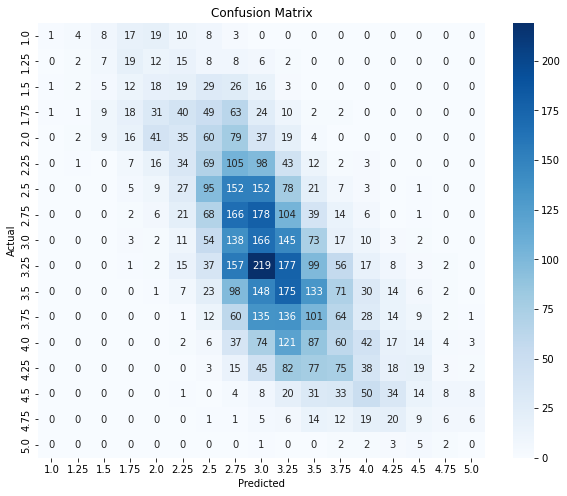

Accuracy: 0.1575
0.3784909


In [8]:
modelCNN = CNN().to(device)
optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#optimizer = optim.Adadelta(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
#lr = 0.001
train_model(modelCNN, optimizer, num_epochs=50)

Mean Squared Error: 0.4643 and Mean Absolute Error: 0.5510


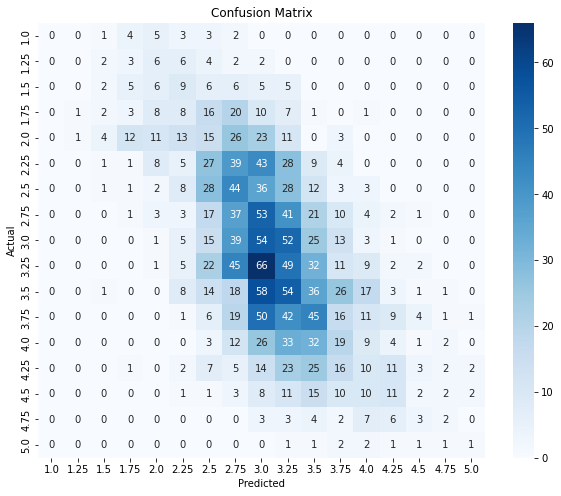

Accuracy: 0.1279


In [9]:
mse = evaluate_model(modelCNN, test_loader,conf=True)


In [10]:
print(mse)

0.46433336


In [11]:
# # Define learning rates and weight decays to search
# learning_rates = [0.1, 0.01, 0.001]
# weight_decays = [0.01, 0.001, 0.0001]

# # Dictionary to store MSE values for each combination
# mse_results = {}

# # Iterate over each combination of hyperparameters
# for lr in learning_rates:
#     for weight_decay in weight_decays:
#         # Create the model and optimizer with the current hyperparameters
#         modelCNN = CNN().to(device)
#         optimizer = optim.Adagrad(modelCNN.parameters(), lr=lr, weight_decay=weight_decay)
        
#         # Train the model
#         train_model(modelCNN, optimizer, num_epochs=25)
        
#         # Evaluate the model
#         mse = evaluate_model(modelCNN, test_loader, conf=True)
        
#         # Store the MSE value for the current combination of hyperparameters
#         mse_results[(lr, weight_decay)] = mse

# # Print the MSE values in a table
# print("Learning Rate\tWeight Decay\tMSE")
# for lr, weight_decay in sorted(mse_results.keys()):
#     mse = mse_results[(lr, weight_decay)]
#     print(f"{lr}\t\t{weight_decay}\t\t{mse}")

In [12]:
# print("Learning Rate\tWeight Decay\tMSE")
# for lr, weight_decay in sorted(mse_results.keys()):
#     mse = mse_results[(lr, weight_decay)]
#     print(f"{lr}\t\t{weight_decay}\t\t{mse}")

c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:02<02:11,  2.69s/it]

Epoch [1/50], Loss: 1.8839
--------------------------------------------------


  4%|▍         | 2/50 [00:05<02:10,  2.73s/it]

Epoch [2/50], Loss: 0.8427
--------------------------------------------------
Epoch [3/50], Loss: 0.7017


  6%|▌         | 3/50 [00:08<02:23,  3.06s/it]

Mean Squared Error: 0.7447 and Mean Absolute Error: 0.6863
0.7446538
--------------------------------------------------
Epoch [4/50], Loss: 0.6626


  8%|▊         | 4/50 [00:12<02:28,  3.23s/it]

Mean Squared Error: 0.6839 and Mean Absolute Error: 0.6805
0.6839003
--------------------------------------------------
Epoch [5/50], Loss: 0.6274


 10%|█         | 5/50 [00:16<02:32,  3.40s/it]

Mean Squared Error: 0.6699 and Mean Absolute Error: 0.6526
0.6699238
--------------------------------------------------
Epoch [6/50], Loss: 0.5876


 12%|█▏        | 6/50 [00:19<02:32,  3.47s/it]

Mean Squared Error: 0.6245 and Mean Absolute Error: 0.6487
0.62445253
--------------------------------------------------
Epoch [7/50], Loss: 0.5592


 14%|█▍        | 7/50 [00:23<02:29,  3.47s/it]

Mean Squared Error: 0.6067 and Mean Absolute Error: 0.6276
0.6067468
--------------------------------------------------
Epoch [8/50], Loss: 0.5432


 16%|█▌        | 8/50 [00:26<02:28,  3.54s/it]

Mean Squared Error: 0.5730 and Mean Absolute Error: 0.6182
0.5729661
--------------------------------------------------
Epoch [9/50], Loss: 0.5417


 18%|█▊        | 9/50 [00:30<02:25,  3.56s/it]

Mean Squared Error: 0.5593 and Mean Absolute Error: 0.6083
0.55927414
--------------------------------------------------
Epoch [10/50], Loss: 0.5236


 20%|██        | 10/50 [00:34<02:23,  3.58s/it]

Mean Squared Error: 0.5767 and Mean Absolute Error: 0.6130
0.57670385
--------------------------------------------------
Epoch [11/50], Loss: 0.5175


 22%|██▏       | 11/50 [00:37<02:19,  3.59s/it]

Mean Squared Error: 0.5516 and Mean Absolute Error: 0.6067
0.5515872
--------------------------------------------------
Epoch [12/50], Loss: 0.5123


 24%|██▍       | 12/50 [00:41<02:16,  3.59s/it]

Mean Squared Error: 0.5373 and Mean Absolute Error: 0.5969
0.5373384
--------------------------------------------------
Epoch [13/50], Loss: 0.4989


 26%|██▌       | 13/50 [00:44<02:13,  3.60s/it]

Mean Squared Error: 0.5487 and Mean Absolute Error: 0.5965
0.5486667
--------------------------------------------------
Epoch [14/50], Loss: 0.4781


 28%|██▊       | 14/50 [00:48<02:09,  3.59s/it]

Mean Squared Error: 0.5322 and Mean Absolute Error: 0.5932
0.5322437
--------------------------------------------------
Epoch [15/50], Loss: 0.4833


 30%|███       | 15/50 [00:52<02:05,  3.59s/it]

Mean Squared Error: 0.5267 and Mean Absolute Error: 0.5878
0.52666664
--------------------------------------------------
Epoch [16/50], Loss: 0.4814


 32%|███▏      | 16/50 [00:55<02:02,  3.59s/it]

Mean Squared Error: 0.5296 and Mean Absolute Error: 0.5917
0.5295985
--------------------------------------------------
Epoch [17/50], Loss: 0.4698


 34%|███▍      | 17/50 [00:59<01:58,  3.60s/it]

Mean Squared Error: 0.5221 and Mean Absolute Error: 0.5862
0.52212965
--------------------------------------------------
Epoch [18/50], Loss: 0.4700


 36%|███▌      | 18/50 [01:02<01:55,  3.62s/it]

Mean Squared Error: 0.5218 and Mean Absolute Error: 0.5874
0.5217922
--------------------------------------------------
Epoch [19/50], Loss: 0.4688


 38%|███▊      | 19/50 [01:06<01:52,  3.63s/it]

Mean Squared Error: 0.5202 and Mean Absolute Error: 0.5880
0.52016205
--------------------------------------------------
Epoch [20/50], Loss: 0.4612


 40%|████      | 20/50 [01:10<01:49,  3.64s/it]

Mean Squared Error: 0.5135 and Mean Absolute Error: 0.5828
0.51352316
--------------------------------------------------
Epoch [21/50], Loss: 0.4597


 42%|████▏     | 21/50 [01:14<01:47,  3.70s/it]

Mean Squared Error: 0.5016 and Mean Absolute Error: 0.5780
0.5015545
--------------------------------------------------
Epoch [22/50], Loss: 0.4593


 44%|████▍     | 22/50 [01:17<01:43,  3.68s/it]

Mean Squared Error: 0.5042 and Mean Absolute Error: 0.5811
0.5042153
--------------------------------------------------
Epoch [23/50], Loss: 0.4460


 46%|████▌     | 23/50 [01:21<01:38,  3.65s/it]

Mean Squared Error: 0.5118 and Mean Absolute Error: 0.5812
0.51184094
--------------------------------------------------
Epoch [24/50], Loss: 0.4554


 48%|████▊     | 24/50 [01:24<01:34,  3.65s/it]

Mean Squared Error: 0.5084 and Mean Absolute Error: 0.5809
0.50840074
--------------------------------------------------
Epoch [25/50], Loss: 0.4400


 50%|█████     | 25/50 [01:28<01:31,  3.65s/it]

Mean Squared Error: 0.5048 and Mean Absolute Error: 0.5772
0.504764
--------------------------------------------------
Epoch [26/50], Loss: 0.4396


 52%|█████▏    | 26/50 [01:32<01:27,  3.65s/it]

Mean Squared Error: 0.5007 and Mean Absolute Error: 0.5790
0.50069326
--------------------------------------------------
Epoch [27/50], Loss: 0.4407


 54%|█████▍    | 27/50 [01:35<01:23,  3.63s/it]

Mean Squared Error: 0.5137 and Mean Absolute Error: 0.5805
0.5137389
--------------------------------------------------
Epoch [28/50], Loss: 0.4349


 56%|█████▌    | 28/50 [01:39<01:20,  3.65s/it]

Mean Squared Error: 0.4988 and Mean Absolute Error: 0.5759
0.4988405
--------------------------------------------------
Epoch [29/50], Loss: 0.4383


 58%|█████▊    | 29/50 [01:43<01:16,  3.66s/it]

Mean Squared Error: 0.4993 and Mean Absolute Error: 0.5802
0.49927545
--------------------------------------------------
Epoch [30/50], Loss: 0.4230


 60%|██████    | 30/50 [01:46<01:13,  3.65s/it]

Mean Squared Error: 0.5007 and Mean Absolute Error: 0.5728
0.5007117
--------------------------------------------------
Epoch [31/50], Loss: 0.4305


 62%|██████▏   | 31/50 [01:50<01:09,  3.66s/it]

Mean Squared Error: 0.4894 and Mean Absolute Error: 0.5725
0.48936507
--------------------------------------------------
Epoch [32/50], Loss: 0.4193


 64%|██████▍   | 32/50 [01:54<01:05,  3.64s/it]

Mean Squared Error: 0.4898 and Mean Absolute Error: 0.5709
0.48980612
--------------------------------------------------
Epoch [33/50], Loss: 0.4189


 66%|██████▌   | 33/50 [01:57<01:01,  3.62s/it]

Mean Squared Error: 0.4972 and Mean Absolute Error: 0.5746
0.4972314
--------------------------------------------------
Epoch [34/50], Loss: 0.4185


 68%|██████▊   | 34/50 [02:01<00:57,  3.62s/it]

Mean Squared Error: 0.5030 and Mean Absolute Error: 0.5767
0.5029601
--------------------------------------------------
Epoch [35/50], Loss: 0.4203


 70%|███████   | 35/50 [02:04<00:54,  3.62s/it]

Mean Squared Error: 0.4861 and Mean Absolute Error: 0.5672
0.4860504
--------------------------------------------------
Epoch [36/50], Loss: 0.4121


 72%|███████▏  | 36/50 [02:08<00:50,  3.61s/it]

Mean Squared Error: 0.4795 and Mean Absolute Error: 0.5674
0.47948697
--------------------------------------------------
Epoch [37/50], Loss: 0.4151


 74%|███████▍  | 37/50 [02:12<00:47,  3.62s/it]

Mean Squared Error: 0.4850 and Mean Absolute Error: 0.5661
0.48496932
--------------------------------------------------
Epoch [38/50], Loss: 0.4112


 76%|███████▌  | 38/50 [02:15<00:43,  3.64s/it]

Mean Squared Error: 0.4989 and Mean Absolute Error: 0.5726
0.49888715
--------------------------------------------------
Epoch [39/50], Loss: 0.4069


 78%|███████▊  | 39/50 [02:19<00:40,  3.64s/it]

Mean Squared Error: 0.4911 and Mean Absolute Error: 0.5684
0.49110138
--------------------------------------------------
Epoch [40/50], Loss: 0.4115


 80%|████████  | 40/50 [02:23<00:36,  3.64s/it]

Mean Squared Error: 0.4849 and Mean Absolute Error: 0.5666
0.4849017
--------------------------------------------------
Epoch [41/50], Loss: 0.4038


 82%|████████▏ | 41/50 [02:26<00:32,  3.65s/it]

Mean Squared Error: 0.4933 and Mean Absolute Error: 0.5736
0.49332973
--------------------------------------------------
Epoch [42/50], Loss: 0.4141


 84%|████████▍ | 42/50 [02:30<00:29,  3.71s/it]

Mean Squared Error: 0.5028 and Mean Absolute Error: 0.5713
0.5027865
--------------------------------------------------
Epoch [43/50], Loss: 0.3981


 86%|████████▌ | 43/50 [02:34<00:25,  3.70s/it]

Mean Squared Error: 0.4754 and Mean Absolute Error: 0.5607
0.475418
--------------------------------------------------
Epoch [44/50], Loss: 0.4074


 88%|████████▊ | 44/50 [02:37<00:22,  3.67s/it]

Mean Squared Error: 0.4839 and Mean Absolute Error: 0.5647
0.48388895
--------------------------------------------------
Epoch [45/50], Loss: 0.3984


 90%|█████████ | 45/50 [02:41<00:18,  3.65s/it]

Mean Squared Error: 0.4927 and Mean Absolute Error: 0.5698
0.49270368
--------------------------------------------------
Epoch [46/50], Loss: 0.4007


 92%|█████████▏| 46/50 [02:45<00:14,  3.64s/it]

Mean Squared Error: 0.4951 and Mean Absolute Error: 0.5716
0.4951058
--------------------------------------------------
Epoch [47/50], Loss: 0.3937


 94%|█████████▍| 47/50 [02:48<00:10,  3.65s/it]

Mean Squared Error: 0.4882 and Mean Absolute Error: 0.5727
0.4881988
--------------------------------------------------
Epoch [48/50], Loss: 0.3925


 96%|█████████▌| 48/50 [02:52<00:07,  3.67s/it]

Mean Squared Error: 0.4790 and Mean Absolute Error: 0.5666
0.4790077
--------------------------------------------------
Epoch [49/50], Loss: 0.3858


 98%|█████████▊| 49/50 [02:56<00:03,  3.66s/it]

Mean Squared Error: 0.4928 and Mean Absolute Error: 0.5676
0.49278957
--------------------------------------------------
Epoch [50/50], Loss: 0.3888


100%|██████████| 50/50 [02:59<00:00,  3.60s/it]

Mean Squared Error: 0.4782 and Mean Absolute Error: 0.5629
0.47819182
--------------------------------------------------


Mean Squared Error: 0.3811 and Mean Absolute Error: 0.4970


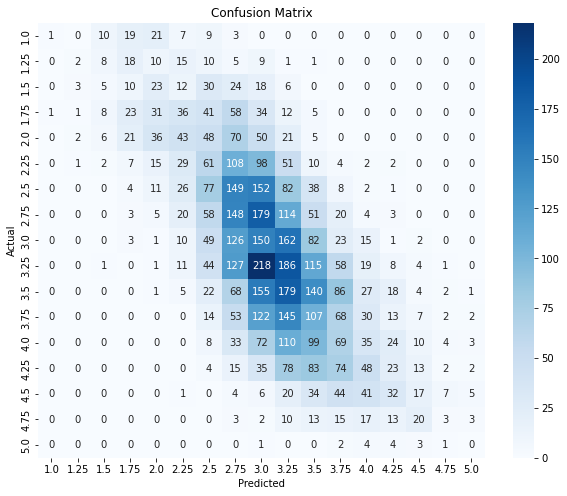

Accuracy: 0.1513
0.38112363
Mean Squared Error: 0.3816 and Mean Absolute Error: 0.4983


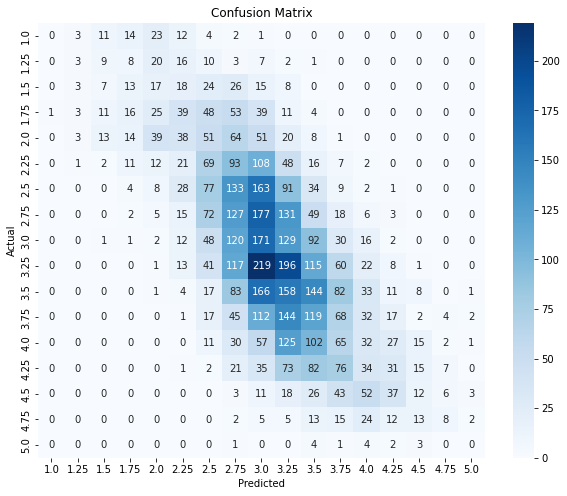

c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Accuracy: 0.1527


  2%|▏         | 1/50 [00:02<02:17,  2.80s/it]

Epoch [1/50], Loss: 1.8836
--------------------------------------------------


  4%|▍         | 2/50 [00:05<02:13,  2.79s/it]

Epoch [2/50], Loss: 0.8423
--------------------------------------------------
Epoch [3/50], Loss: 0.7032


  6%|▌         | 3/50 [00:09<02:29,  3.19s/it]

Mean Squared Error: 0.7486 and Mean Absolute Error: 0.6880
0.7485888
--------------------------------------------------
Epoch [4/50], Loss: 0.6635


  8%|▊         | 4/50 [00:12<02:35,  3.38s/it]

Mean Squared Error: 0.6816 and Mean Absolute Error: 0.6785
0.6815567
--------------------------------------------------
Epoch [5/50], Loss: 0.6262


 10%|█         | 5/50 [00:16<02:35,  3.45s/it]

Mean Squared Error: 0.6642 and Mean Absolute Error: 0.6497
0.66418517
--------------------------------------------------
Epoch [6/50], Loss: 0.5883


 12%|█▏        | 6/50 [00:20<02:34,  3.51s/it]

Mean Squared Error: 0.6206 and Mean Absolute Error: 0.6453
0.6205814
--------------------------------------------------
Epoch [7/50], Loss: 0.5586


 14%|█▍        | 7/50 [00:23<02:32,  3.54s/it]

Mean Squared Error: 0.6088 and Mean Absolute Error: 0.6294
0.6087923
--------------------------------------------------
Epoch [8/50], Loss: 0.5406


 16%|█▌        | 8/50 [00:27<02:29,  3.56s/it]

Mean Squared Error: 0.5776 and Mean Absolute Error: 0.6204
0.5775901
--------------------------------------------------
Epoch [9/50], Loss: 0.5408


 18%|█▊        | 9/50 [00:30<02:26,  3.57s/it]

Mean Squared Error: 0.5590 and Mean Absolute Error: 0.6072
0.5590307
--------------------------------------------------
Epoch [10/50], Loss: 0.5243


 20%|██        | 10/50 [00:34<02:23,  3.58s/it]

Mean Squared Error: 0.5701 and Mean Absolute Error: 0.6097
0.5701183
--------------------------------------------------
Epoch [11/50], Loss: 0.5174


 22%|██▏       | 11/50 [00:38<02:20,  3.59s/it]

Mean Squared Error: 0.5531 and Mean Absolute Error: 0.6078
0.55310315
--------------------------------------------------
Epoch [12/50], Loss: 0.5098


 24%|██▍       | 12/50 [00:41<02:16,  3.59s/it]

Mean Squared Error: 0.5383 and Mean Absolute Error: 0.5959
0.5383329
--------------------------------------------------
Epoch [13/50], Loss: 0.5005


 26%|██▌       | 13/50 [00:45<02:12,  3.59s/it]

Mean Squared Error: 0.5422 and Mean Absolute Error: 0.5933
0.5421675
--------------------------------------------------
Epoch [14/50], Loss: 0.4771


 28%|██▊       | 14/50 [00:48<02:09,  3.59s/it]

Mean Squared Error: 0.5356 and Mean Absolute Error: 0.5961
0.535626
--------------------------------------------------
Epoch [15/50], Loss: 0.4819


 30%|███       | 15/50 [00:52<02:06,  3.61s/it]

Mean Squared Error: 0.5241 and Mean Absolute Error: 0.5852
0.52411896
--------------------------------------------------
Epoch [16/50], Loss: 0.4820


 32%|███▏      | 16/50 [00:56<02:04,  3.65s/it]

Mean Squared Error: 0.5288 and Mean Absolute Error: 0.5906
0.52878016
--------------------------------------------------
Epoch [17/50], Loss: 0.4687


 34%|███▍      | 17/50 [00:59<02:00,  3.65s/it]

Mean Squared Error: 0.5206 and Mean Absolute Error: 0.5851
0.520556
--------------------------------------------------
Epoch [18/50], Loss: 0.4728


 36%|███▌      | 18/50 [01:03<01:56,  3.64s/it]

Mean Squared Error: 0.5214 and Mean Absolute Error: 0.5878
0.5214115
--------------------------------------------------
Epoch [19/50], Loss: 0.4673


 38%|███▊      | 19/50 [01:07<01:52,  3.64s/it]

Mean Squared Error: 0.5232 and Mean Absolute Error: 0.5885
0.5232287
--------------------------------------------------
Epoch [20/50], Loss: 0.4643


 40%|████      | 20/50 [01:10<01:49,  3.64s/it]

Mean Squared Error: 0.5110 and Mean Absolute Error: 0.5806
0.5109687
--------------------------------------------------
Epoch [21/50], Loss: 0.4581


 42%|████▏     | 21/50 [01:14<01:44,  3.62s/it]

Mean Squared Error: 0.5055 and Mean Absolute Error: 0.5806
0.50553113
--------------------------------------------------
Epoch [22/50], Loss: 0.4584


 44%|████▍     | 22/50 [01:18<01:41,  3.61s/it]

Mean Squared Error: 0.5026 and Mean Absolute Error: 0.5800
0.50258636
--------------------------------------------------
Epoch [23/50], Loss: 0.4469


 46%|████▌     | 23/50 [01:21<01:37,  3.61s/it]

Mean Squared Error: 0.5116 and Mean Absolute Error: 0.5814
0.51162934
--------------------------------------------------
Epoch [24/50], Loss: 0.4555


 48%|████▊     | 24/50 [01:25<01:34,  3.62s/it]

Mean Squared Error: 0.5070 and Mean Absolute Error: 0.5809
0.5069702
--------------------------------------------------
Epoch [25/50], Loss: 0.4387


 50%|█████     | 25/50 [01:28<01:31,  3.65s/it]

Mean Squared Error: 0.5038 and Mean Absolute Error: 0.5761
0.50381064
--------------------------------------------------
Epoch [26/50], Loss: 0.4370


 52%|█████▏    | 26/50 [01:32<01:27,  3.66s/it]

Mean Squared Error: 0.5029 and Mean Absolute Error: 0.5790
0.5029048
--------------------------------------------------
Epoch [27/50], Loss: 0.4416


 54%|█████▍    | 27/50 [01:36<01:24,  3.66s/it]

Mean Squared Error: 0.5150 and Mean Absolute Error: 0.5811
0.5150071
--------------------------------------------------
Epoch [28/50], Loss: 0.4313


 56%|█████▌    | 28/50 [01:39<01:20,  3.65s/it]

Mean Squared Error: 0.4936 and Mean Absolute Error: 0.5732
0.493591
--------------------------------------------------
Epoch [29/50], Loss: 0.4348


 58%|█████▊    | 29/50 [01:43<01:16,  3.65s/it]

Mean Squared Error: 0.4959 and Mean Absolute Error: 0.5770
0.49590537
--------------------------------------------------
Epoch [30/50], Loss: 0.4226


 60%|██████    | 30/50 [01:47<01:12,  3.65s/it]

Mean Squared Error: 0.5029 and Mean Absolute Error: 0.5740
0.50293094
--------------------------------------------------
Epoch [31/50], Loss: 0.4276


 62%|██████▏   | 31/50 [01:50<01:08,  3.63s/it]

Mean Squared Error: 0.4903 and Mean Absolute Error: 0.5724
0.49034506
--------------------------------------------------
Epoch [32/50], Loss: 0.4184


 64%|██████▍   | 32/50 [01:54<01:05,  3.63s/it]

Mean Squared Error: 0.4928 and Mean Absolute Error: 0.5729
0.492803
--------------------------------------------------
Epoch [33/50], Loss: 0.4190


 66%|██████▌   | 33/50 [01:58<01:01,  3.62s/it]

Mean Squared Error: 0.4940 and Mean Absolute Error: 0.5740
0.49401784
--------------------------------------------------
Epoch [34/50], Loss: 0.4145


 68%|██████▊   | 34/50 [02:01<00:57,  3.62s/it]

Mean Squared Error: 0.5005 and Mean Absolute Error: 0.5755
0.5005449
--------------------------------------------------
Epoch [35/50], Loss: 0.4203


 70%|███████   | 35/50 [02:05<00:54,  3.63s/it]

Mean Squared Error: 0.4856 and Mean Absolute Error: 0.5673
0.48561454
--------------------------------------------------
Epoch [36/50], Loss: 0.4119


 72%|███████▏  | 36/50 [02:09<00:51,  3.66s/it]

Mean Squared Error: 0.4812 and Mean Absolute Error: 0.5680
0.48122704
--------------------------------------------------
Epoch [37/50], Loss: 0.4141


 74%|███████▍  | 37/50 [02:12<00:47,  3.66s/it]

Mean Squared Error: 0.4855 and Mean Absolute Error: 0.5649
0.48545614
--------------------------------------------------
Epoch [38/50], Loss: 0.4092


 76%|███████▌  | 38/50 [02:16<00:43,  3.65s/it]

Mean Squared Error: 0.5032 and Mean Absolute Error: 0.5748
0.5032
--------------------------------------------------
Epoch [39/50], Loss: 0.4073


 78%|███████▊  | 39/50 [02:19<00:40,  3.64s/it]

Mean Squared Error: 0.4847 and Mean Absolute Error: 0.5644
0.4846679
--------------------------------------------------
Epoch [40/50], Loss: 0.4073


 80%|████████  | 40/50 [02:23<00:36,  3.63s/it]

Mean Squared Error: 0.4826 and Mean Absolute Error: 0.5672
0.48258623
--------------------------------------------------
Epoch [41/50], Loss: 0.4031


 82%|████████▏ | 41/50 [02:27<00:32,  3.61s/it]

Mean Squared Error: 0.4881 and Mean Absolute Error: 0.5707
0.48814875
--------------------------------------------------
Epoch [42/50], Loss: 0.4114


 84%|████████▍ | 42/50 [02:30<00:28,  3.62s/it]

Mean Squared Error: 0.5074 and Mean Absolute Error: 0.5723
0.50744885
--------------------------------------------------
Epoch [43/50], Loss: 0.3973


 86%|████████▌ | 43/50 [02:34<00:25,  3.62s/it]

Mean Squared Error: 0.4768 and Mean Absolute Error: 0.5594
0.4767914
--------------------------------------------------
Epoch [44/50], Loss: 0.4046


 88%|████████▊ | 44/50 [02:38<00:21,  3.63s/it]

Mean Squared Error: 0.4884 and Mean Absolute Error: 0.5677
0.48840562
--------------------------------------------------
Epoch [45/50], Loss: 0.3976


 90%|█████████ | 45/50 [02:41<00:18,  3.68s/it]

Mean Squared Error: 0.4862 and Mean Absolute Error: 0.5660
0.48620373
--------------------------------------------------
Epoch [46/50], Loss: 0.3984


 92%|█████████▏| 46/50 [02:45<00:14,  3.68s/it]

Mean Squared Error: 0.4937 and Mean Absolute Error: 0.5712
0.49365246
--------------------------------------------------
Epoch [47/50], Loss: 0.3909


 94%|█████████▍| 47/50 [02:49<00:11,  3.67s/it]

Mean Squared Error: 0.4807 and Mean Absolute Error: 0.5694
0.48068103
--------------------------------------------------
Epoch [48/50], Loss: 0.3929


 96%|█████████▌| 48/50 [02:52<00:07,  3.65s/it]

Mean Squared Error: 0.4782 and Mean Absolute Error: 0.5658
0.47819644
--------------------------------------------------
Epoch [49/50], Loss: 0.3803


 98%|█████████▊| 49/50 [02:56<00:03,  3.66s/it]

Mean Squared Error: 0.4796 and Mean Absolute Error: 0.5615
0.47960234
--------------------------------------------------
Epoch [50/50], Loss: 0.3854


100%|██████████| 50/50 [03:00<00:00,  3.60s/it]

Mean Squared Error: 0.4896 and Mean Absolute Error: 0.5688
0.48956186
--------------------------------------------------


Mean Squared Error: 0.3833 and Mean Absolute Error: 0.4973


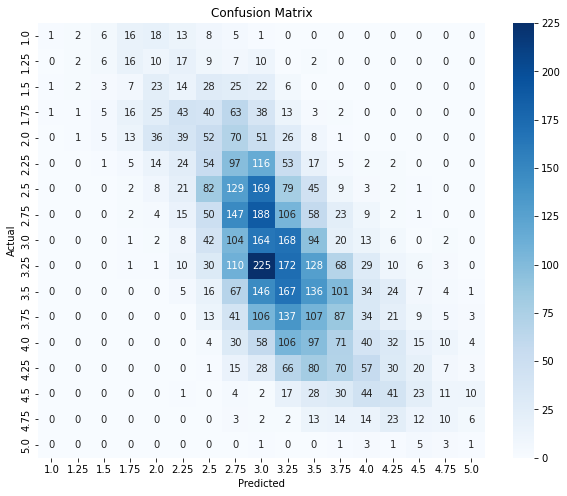

Accuracy: 0.1562
0.38331166
Mean Squared Error: 0.3827 and Mean Absolute Error: 0.4986


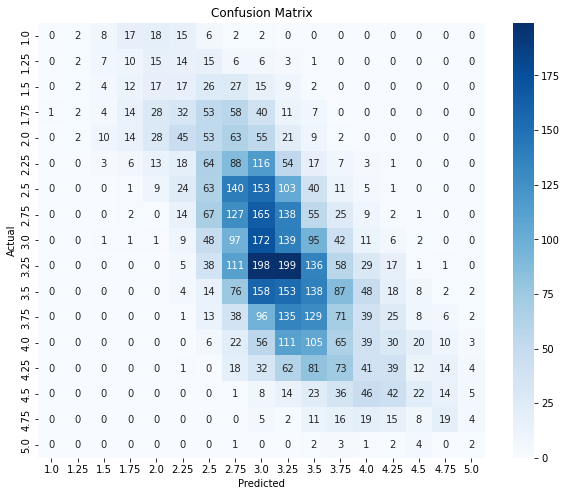

c:\Users\20211922\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Accuracy: 0.1535


  2%|▏         | 1/50 [00:02<02:16,  2.79s/it]

Epoch [1/50], Loss: 1.8833
--------------------------------------------------


  4%|▍         | 2/50 [00:05<02:13,  2.78s/it]

Epoch [2/50], Loss: 0.8412
--------------------------------------------------
Epoch [3/50], Loss: 0.7016


  6%|▌         | 3/50 [00:09<02:28,  3.15s/it]

Mean Squared Error: 0.7467 and Mean Absolute Error: 0.6871
0.7467058
--------------------------------------------------
Epoch [4/50], Loss: 0.6631


  8%|▊         | 4/50 [00:12<02:33,  3.33s/it]

Mean Squared Error: 0.6802 and Mean Absolute Error: 0.6777
0.68022573
--------------------------------------------------
Epoch [5/50], Loss: 0.6254


 10%|█         | 5/50 [00:16<02:34,  3.44s/it]

Mean Squared Error: 0.6623 and Mean Absolute Error: 0.6493
0.66233927
--------------------------------------------------
Epoch [6/50], Loss: 0.5880


 12%|█▏        | 6/50 [00:20<02:34,  3.51s/it]

Mean Squared Error: 0.6204 and Mean Absolute Error: 0.6453
0.6203714
--------------------------------------------------
Epoch [7/50], Loss: 0.5574


 14%|█▍        | 7/50 [00:23<02:33,  3.58s/it]

Mean Squared Error: 0.6086 and Mean Absolute Error: 0.6290
0.6085522
--------------------------------------------------
Epoch [8/50], Loss: 0.5396


 16%|█▌        | 8/50 [00:27<02:30,  3.59s/it]

Mean Squared Error: 0.5777 and Mean Absolute Error: 0.6205
0.5777087
--------------------------------------------------
Epoch [9/50], Loss: 0.5396


 18%|█▊        | 9/50 [00:30<02:27,  3.59s/it]

Mean Squared Error: 0.5576 and Mean Absolute Error: 0.6062
0.5575781
--------------------------------------------------
Epoch [10/50], Loss: 0.5226


 20%|██        | 10/50 [00:34<02:23,  3.60s/it]

Mean Squared Error: 0.5691 and Mean Absolute Error: 0.6096
0.56912494
--------------------------------------------------
Epoch [11/50], Loss: 0.5157


 22%|██▏       | 11/50 [00:38<02:20,  3.60s/it]

Mean Squared Error: 0.5543 and Mean Absolute Error: 0.6089
0.55433905
--------------------------------------------------
Epoch [12/50], Loss: 0.5076


 24%|██▍       | 12/50 [00:41<02:17,  3.61s/it]

Mean Squared Error: 0.5406 and Mean Absolute Error: 0.5967
0.5405994
--------------------------------------------------
Epoch [13/50], Loss: 0.4984


 26%|██▌       | 13/50 [00:45<02:14,  3.63s/it]

Mean Squared Error: 0.5407 and Mean Absolute Error: 0.5927
0.5406587
--------------------------------------------------
Epoch [14/50], Loss: 0.4748


 28%|██▊       | 14/50 [00:49<02:11,  3.65s/it]

Mean Squared Error: 0.5336 and Mean Absolute Error: 0.5950
0.5336006
--------------------------------------------------
Epoch [15/50], Loss: 0.4792


 30%|███       | 15/50 [00:52<02:07,  3.65s/it]

Mean Squared Error: 0.5235 and Mean Absolute Error: 0.5841
0.5234869
--------------------------------------------------
Epoch [16/50], Loss: 0.4805


 32%|███▏      | 16/50 [00:56<02:04,  3.66s/it]

Mean Squared Error: 0.5287 and Mean Absolute Error: 0.5898
0.5286882
--------------------------------------------------
Epoch [17/50], Loss: 0.4658


 34%|███▍      | 17/50 [01:00<02:00,  3.66s/it]

Mean Squared Error: 0.5212 and Mean Absolute Error: 0.5856
0.5211501
--------------------------------------------------
Epoch [18/50], Loss: 0.4716


 36%|███▌      | 18/50 [01:03<01:56,  3.65s/it]

Mean Squared Error: 0.5198 and Mean Absolute Error: 0.5863
0.5197841
--------------------------------------------------
Epoch [19/50], Loss: 0.4648


 38%|███▊      | 19/50 [01:07<01:52,  3.64s/it]

Mean Squared Error: 0.5270 and Mean Absolute Error: 0.5908
0.52701735
--------------------------------------------------
Epoch [20/50], Loss: 0.4610


 40%|████      | 20/50 [01:11<01:49,  3.64s/it]

Mean Squared Error: 0.5069 and Mean Absolute Error: 0.5786
0.5068639
--------------------------------------------------
Epoch [21/50], Loss: 0.4567


 42%|████▏     | 21/50 [01:14<01:44,  3.62s/it]

Mean Squared Error: 0.5041 and Mean Absolute Error: 0.5796
0.50411975
--------------------------------------------------
Epoch [22/50], Loss: 0.4546


 44%|████▍     | 22/50 [01:18<01:41,  3.62s/it]

Mean Squared Error: 0.5028 and Mean Absolute Error: 0.5798
0.5028063
--------------------------------------------------
Epoch [23/50], Loss: 0.4462


 46%|████▌     | 23/50 [01:21<01:38,  3.65s/it]

Mean Squared Error: 0.5097 and Mean Absolute Error: 0.5799
0.5097439
--------------------------------------------------
Epoch [24/50], Loss: 0.4529


 48%|████▊     | 24/50 [01:25<01:35,  3.65s/it]

Mean Squared Error: 0.5088 and Mean Absolute Error: 0.5819
0.5087905
--------------------------------------------------
Epoch [25/50], Loss: 0.4386


 50%|█████     | 25/50 [01:29<01:31,  3.64s/it]

Mean Squared Error: 0.5023 and Mean Absolute Error: 0.5761
0.502338
--------------------------------------------------
Epoch [26/50], Loss: 0.4363


 52%|█████▏    | 26/50 [01:32<01:27,  3.65s/it]

Mean Squared Error: 0.5059 and Mean Absolute Error: 0.5815
0.5058537
--------------------------------------------------
Epoch [27/50], Loss: 0.4393


 54%|█████▍    | 27/50 [01:36<01:23,  3.64s/it]

Mean Squared Error: 0.5096 and Mean Absolute Error: 0.5792
0.5095921
--------------------------------------------------
Epoch [28/50], Loss: 0.4319


 56%|█████▌    | 28/50 [01:40<01:19,  3.62s/it]

Mean Squared Error: 0.4974 and Mean Absolute Error: 0.5759
0.49740374
--------------------------------------------------
Epoch [29/50], Loss: 0.4346


 58%|█████▊    | 29/50 [01:43<01:15,  3.61s/it]

Mean Squared Error: 0.4974 and Mean Absolute Error: 0.5772
0.4973859
--------------------------------------------------
Epoch [30/50], Loss: 0.4223


 60%|██████    | 30/50 [01:47<01:12,  3.61s/it]

Mean Squared Error: 0.5068 and Mean Absolute Error: 0.5755
0.5067551
--------------------------------------------------
Epoch [31/50], Loss: 0.4255


 62%|██████▏   | 31/50 [01:50<01:08,  3.60s/it]

Mean Squared Error: 0.4903 and Mean Absolute Error: 0.5720
0.4903315
--------------------------------------------------
Epoch [32/50], Loss: 0.4205


 64%|██████▍   | 32/50 [01:54<01:05,  3.61s/it]

Mean Squared Error: 0.4930 and Mean Absolute Error: 0.5732
0.49302918
--------------------------------------------------
Epoch [33/50], Loss: 0.4156


 66%|██████▌   | 33/50 [01:58<01:01,  3.63s/it]

Mean Squared Error: 0.4996 and Mean Absolute Error: 0.5745
0.49959272
--------------------------------------------------
Epoch [34/50], Loss: 0.4164


 68%|██████▊   | 34/50 [02:01<00:58,  3.65s/it]

Mean Squared Error: 0.4999 and Mean Absolute Error: 0.5748
0.49990907
--------------------------------------------------
Epoch [35/50], Loss: 0.4156


 70%|███████   | 35/50 [02:05<00:54,  3.64s/it]

Mean Squared Error: 0.4843 and Mean Absolute Error: 0.5672
0.48428765
--------------------------------------------------
Epoch [36/50], Loss: 0.4133


 72%|███████▏  | 36/50 [02:09<00:50,  3.64s/it]

Mean Squared Error: 0.4786 and Mean Absolute Error: 0.5668
0.47859022
--------------------------------------------------
Epoch [37/50], Loss: 0.4098


 74%|███████▍  | 37/50 [02:12<00:47,  3.63s/it]

Mean Squared Error: 0.4888 and Mean Absolute Error: 0.5665
0.48875785
--------------------------------------------------
Epoch [38/50], Loss: 0.4101


 76%|███████▌  | 38/50 [02:16<00:43,  3.62s/it]

Mean Squared Error: 0.4987 and Mean Absolute Error: 0.5720
0.4987208
--------------------------------------------------
Epoch [39/50], Loss: 0.4040


 78%|███████▊  | 39/50 [02:19<00:39,  3.61s/it]

Mean Squared Error: 0.4862 and Mean Absolute Error: 0.5660
0.4862381
--------------------------------------------------
Epoch [40/50], Loss: 0.4085


 80%|████████  | 40/50 [02:23<00:36,  3.62s/it]

Mean Squared Error: 0.4816 and Mean Absolute Error: 0.5660
0.4815692
--------------------------------------------------
Epoch [41/50], Loss: 0.4007


 82%|████████▏ | 41/50 [02:27<00:32,  3.61s/it]

Mean Squared Error: 0.4915 and Mean Absolute Error: 0.5729
0.4915292
--------------------------------------------------
Epoch [42/50], Loss: 0.4109


 84%|████████▍ | 42/50 [02:30<00:28,  3.61s/it]

Mean Squared Error: 0.4965 and Mean Absolute Error: 0.5682
0.49652964
--------------------------------------------------
Epoch [43/50], Loss: 0.3951


 86%|████████▌ | 43/50 [02:34<00:25,  3.64s/it]

Mean Squared Error: 0.4738 and Mean Absolute Error: 0.5582
0.4737661
--------------------------------------------------
Epoch [44/50], Loss: 0.4036


 88%|████████▊ | 44/50 [02:38<00:22,  3.67s/it]

Mean Squared Error: 0.4842 and Mean Absolute Error: 0.5648
0.48424935
--------------------------------------------------
Epoch [45/50], Loss: 0.3975


 90%|█████████ | 45/50 [02:41<00:18,  3.65s/it]

Mean Squared Error: 0.4966 and Mean Absolute Error: 0.5711
0.49656904
--------------------------------------------------
Epoch [46/50], Loss: 0.3981


 92%|█████████▏| 46/50 [02:45<00:14,  3.65s/it]

Mean Squared Error: 0.4884 and Mean Absolute Error: 0.5691
0.48839295
--------------------------------------------------
Epoch [47/50], Loss: 0.3911


 94%|█████████▍| 47/50 [02:49<00:10,  3.63s/it]

Mean Squared Error: 0.4826 and Mean Absolute Error: 0.5703
0.48262483
--------------------------------------------------
Epoch [48/50], Loss: 0.3904


 96%|█████████▌| 48/50 [02:52<00:07,  3.64s/it]

Mean Squared Error: 0.4772 and Mean Absolute Error: 0.5643
0.4771934
--------------------------------------------------
Epoch [49/50], Loss: 0.3825


 98%|█████████▊| 49/50 [02:56<00:03,  3.64s/it]

Mean Squared Error: 0.4883 and Mean Absolute Error: 0.5654
0.48831135
--------------------------------------------------
Epoch [50/50], Loss: 0.3856


100%|██████████| 50/50 [03:00<00:00,  3.61s/it]

Mean Squared Error: 0.4777 and Mean Absolute Error: 0.5624
0.47768962
--------------------------------------------------


Mean Squared Error: 0.3786 and Mean Absolute Error: 0.4947


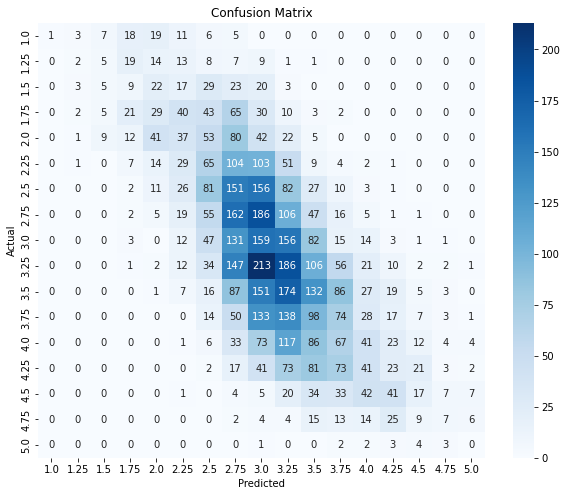

Accuracy: 0.1574
0.37864277
Mean Squared Error: 0.3785 and Mean Absolute Error: 0.4970


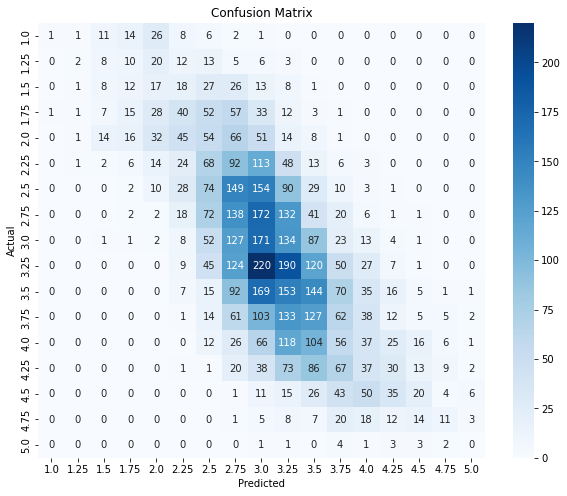

Accuracy: 0.1538
Learning Rate	Weight Decay	MSE
0.001		0.0001		0.378474622964859
0.001		0.001		0.3827227056026459
0.001		0.01		0.3816383481025696


In [13]:
# Define learning rates and weight decays to search
learning_rates = [0.001]
weight_decays = [0.01, 0.001, 0.0001]

# Dictionary to store MSE values for each combination
mse_results = {}

# Iterate over each combination of hyperparameters
for lr in learning_rates:
    for weight_decay in weight_decays:
        # Create the model and optimizer with the current hyperparameters
        modelCNN = CNN().to(device)
        optimizer = optim.Adagrad(modelCNN.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Train the model
        train_model(modelCNN, optimizer, num_epochs=50)
        
        # Evaluate the model
        mse = evaluate_model(modelCNN, train_loader, conf=True)
        
        # Store the MSE value for the current combination of hyperparameters
        mse_results[(lr, weight_decay)] = mse

# Print the MSE values in a table
print("Learning Rate\tWeight Decay\tMSE")
for lr, weight_decay in sorted(mse_results.keys()):
    mse = mse_results[(lr, weight_decay)]
    print(f"{lr}\t\t{weight_decay}\t\t{mse}")